In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_PATH = "covid_jabar_perkembangan_harian.csv"

df = pd.read_csv(DATA_PATH)
df["tanggal"] = pd.to_datetime(df["tanggal"])

print("Kolom:", df.columns.tolist())
print("Wilayah unik:", sorted(df["nama_kab_kota"].unique())[:10], "...")


Kolom: ['tanggal', 'kode_kab_kota', 'nama_kab_kota', 'konfirmasi_total', 'konfirmasi_sembuh', 'konfirmasi_meninggal', 'konfirmasi_aktif', 'konfirmasi_total_daily_growth', 'konfirmasi_sembuh_daily_growth', 'konfirmasi_meninggal_daily_growth', 'konfirmasi_aktif_daily_growth', 'kota_kab_belum_teridentifikasi', 'sembuh_unidentified', 'meninggal_unidentified', 'id']
Wilayah unik: ['Kabupaten Bandung', 'Kabupaten Bandung Barat', 'Kabupaten Bekasi', 'Kabupaten Bogor', 'Kabupaten Ciamis', 'Kabupaten Cianjur', 'Kabupaten Cirebon', 'Kabupaten Garut', 'Kabupaten Indramayu', 'Kabupaten Karawang'] ...


In [2]:
WILAYAH = "Kota Bandung"         
TARGET_COL = "konfirmasi_total"  

START_DATE = "2020-03-01"
END_DATE   = "2021-03-01"

dff = df[df["nama_kab_kota"].str.lower() == WILAYAH.lower()].copy()
dff = dff.sort_values("tanggal")

dff = dff[(dff["tanggal"] >= START_DATE) & (dff["tanggal"] <= END_DATE)]

dff = dff[["tanggal", TARGET_COL]].dropna()

t0 = dff["tanggal"].iloc[0]
t_obs = (dff["tanggal"] - t0).dt.days.to_numpy(dtype=float) 
y_obs = dff[TARGET_COL].to_numpy(dtype=float)

print("Wilayah:", WILAYAH)
print("Periode:", START_DATE, "s/d", END_DATE)
print("n_data:", len(t_obs), "| t_end:", t_obs[-1], "| y_last:", y_obs[-1])


Wilayah: Kota Bandung
Periode: 2020-03-01 s/d 2021-03-01
n_data: 366 | t_end: 365.0 | y_last: 13668.0


In [3]:
# Logistic ODE: dP/dt = r P (1 - P/K)
def deriv(r_vec, x, params):
    # r_vec: array state [P]
    # x: time (hari)
    # params: (r, K)
    r, K = params
    P = r_vec[0]
    dP = r * P * (1.0 - P / K)
    return np.array([dP], float)

def rk4_simulate(params, x_start, x_final, h, y0):

    xaxis = np.array([], float)
    yaxis = np.array([], float)

    r_vec = np.array([y0], float)

    x = float(x_start)
    xf = float(x_final)

    while x <= xf:
        xaxis = np.append(xaxis, x)
        yaxis = np.append(yaxis, r_vec[0])

        k1 = h * deriv(r_vec, x, params)
        k2 = h * deriv(r_vec + k1/2.0, x + h/2.0, params)
        k3 = h * deriv(r_vec + k2/2.0, x + h/2.0, params)
        k4 = h * deriv(r_vec + k3,     x + h,     params)

        r_vec += (k1 + 2*k2 + 2*k3 + k4) / 6.0
        x += h

    return xaxis, yaxis

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, float)
    y_pred = np.asarray(y_pred, float)
    return np.sqrt(np.mean((y_true - y_pred)**2))


TRIAL => r = 0.1 | K = 20502.0 | RMSE = 4522.274064654529


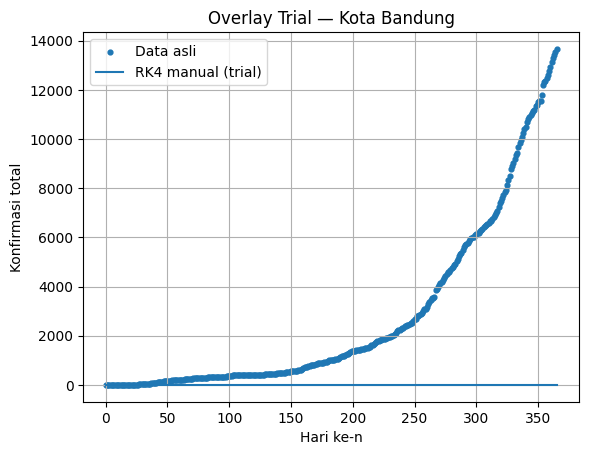

In [4]:
y0 = float(y_obs[0])
x_start = float(t_obs[0])
x_final = float(t_obs[-1])
h = 1.0  # data harian → 1 hari

# trial awal
r_try = 0.10
K_try = y_obs[-1] * 1.5

xaxis_try, ysim_try_grid = rk4_simulate((r_try, K_try), x_start, x_final, h, y0)

# karena t_obs harian dan h=1, grid biasanya pas; tetap aman pakai interp
y_sim_try = np.interp(t_obs, xaxis_try, ysim_try_grid)
e_try = rmse(y_obs, y_sim_try)

print("TRIAL => r =", r_try, "| K =", K_try, "| RMSE =", e_try)

plt.figure()
plt.scatter(t_obs, y_obs, s=12, label="Data asli")
plt.plot(t_obs, y_sim_try, label="RK4 manual (trial)")
plt.xlabel("Hari ke-n")
plt.ylabel("Konfirmasi total")
plt.title(f"Overlay Trial — {WILAYAH}")
plt.legend()
plt.grid(True)
plt.show()


BEST GRID => r = 0.001 | K = 13941.36 | RMSE = 4522.274064654529


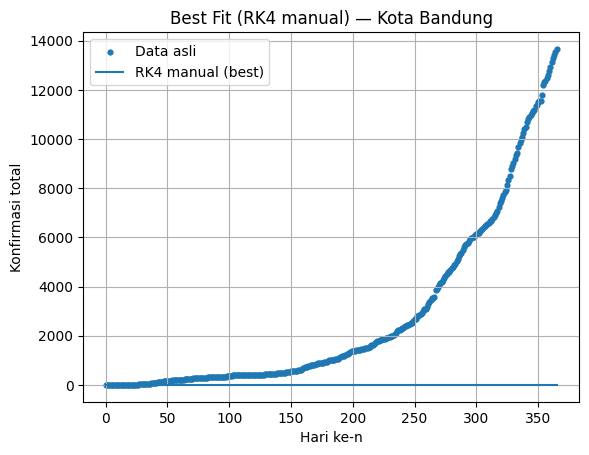

In [5]:
# grid yang lebih “pas” untuk kumulatif: K sedikit di atas nilai akhir periode
r_grid = np.linspace(0.001, 0.60, 90)
K_grid = np.linspace(y_obs[-1] * 1.02, y_obs[-1] * 3.00, 90)

best_rmse = np.inf
best_r = None
best_K = None
best_y = None

for r in r_grid:
    for K in K_grid:
        xaxis, ygrid = rk4_simulate((r, K), x_start, x_final, h, y0)
        y_sim = np.interp(t_obs, xaxis, ygrid)
        e = rmse(y_obs, y_sim)

        if e < best_rmse:
            best_rmse = e
            best_r = float(r)
            best_K = float(K)
            best_y = y_sim

print("BEST GRID => r =", best_r, "| K =", best_K, "| RMSE =", best_rmse)

plt.figure()
plt.scatter(t_obs, y_obs, s=12, label="Data asli")
plt.plot(t_obs, best_y, label="RK4 manual (best)")
plt.xlabel("Hari ke-n")
plt.ylabel("Konfirmasi total")
plt.title(f"Best Fit (RK4 manual) — {WILAYAH}")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
def rk4_step(f, t, y, h, params):
    k1 = f(t,       y,           *params)
    k2 = f(t + h/2, y + h*k1/2,   *params)
    k3 = f(t + h/2, y + h*k2/2,   *params)
    k4 = f(t + h,   y + h*k3,     *params)
    return y + (h/6.0) * (k1 + 2*k2 + 2*k3 + k4)

def rk4_solve(f, t0, y0, t_end, h, params):
    n = int(np.ceil((t_end - t0) / h))
    t_grid = t0 + h*np.arange(n+1)
    y_grid = np.zeros((n+1, len(y0)), dtype=float)
    y_grid[0] = y0

    t = t0
    y = y0.astype(float).copy()
    for i in range(n):
        y = rk4_step(f, t, y, h, params)
        t = t_grid[i+1]
        y_grid[i+1] = y

    return t_grid, y_grid


In [10]:
def simulate_at_obs_times(t_obs, y0_scalar, r, K, h):
    t_start = float(t_obs.min())
    t_end   = float(t_obs.max())

    t_grid, y_grid = rk4_solve(
        logistic_rhs,
        t0=t_start,
        y0=np.array([y0_scalar], dtype=float),
        t_end=t_end,
        h=h,
        params=(r, K)
    )

    # interpolasi supaya y_sim tepat di t_obs
    y_sim = np.interp(t_obs, t_grid, y_grid[:, 0])
    return y_sim

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    return np.sqrt(np.mean((y_true - y_pred)**2))


TRIAL => r: 0.1 K: 169159.5 RMSE: 59570.9940278052


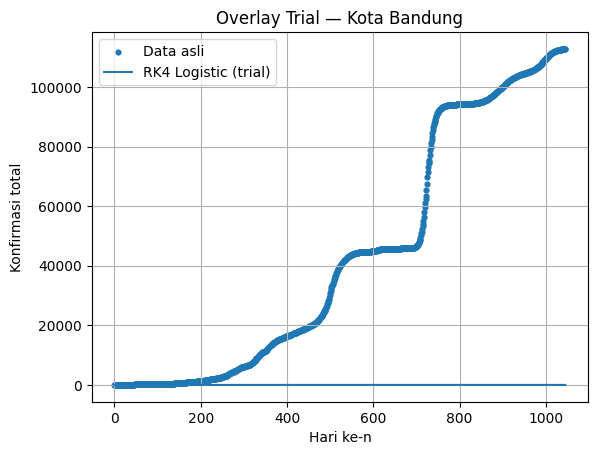

In [11]:
y0 = float(y_obs[0])

# karena data harian, h=1 biasanya OK; kalau mau halus: 0.5 / 0.25
h = 1.0

# trial awal (silakan ubah)
r_try = 0.10
K_try = max(y_obs) * 1.5

y_sim_try = simulate_at_obs_times(t_obs, y0, r_try, K_try, h)
e_try = rmse(y_obs, y_sim_try)

print("TRIAL => r:", r_try, "K:", K_try, "RMSE:", e_try)

plt.figure()
plt.scatter(t_obs, y_obs, s=12, label="Data asli")
plt.plot(t_obs, y_sim_try, label="RK4 Logistic (trial)")
plt.xlabel("Hari ke-n")
plt.ylabel("Konfirmasi total")
plt.title(f"Overlay Trial — {WILAYAH}")
plt.legend()
plt.grid(True)
plt.show()
